In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import numpy as np

# Question 1

In [ ]:
# Read the data from the downloaded csv file
df = pd.read_csv('Test_Dataset.csv')

# Read products category, homepage and the rest as others
page_segments = []
for page in df['Page']:
    if '/produit/' in page:
        page_segments.append('Products')
    elif page == '/':
        page_segments.append('Homepage')
    else:
        page_segments.append('Others')

df['Page Segment'] = page_segments
page_segment_count = df['Page Segment'].value_counts().reset_index()

# Show the data
page_segment_count.head()

,index,Page Segment
0,Others,389176
1,Products,3675
2,Homepage,3425


**Improved version to take all categories based on url of the the page split by //.**

In [ ]:
# Read the data from CSV file
df = pd.read_csv('Test_Dataset.csv')

# Extract the category from the URL by splitting from the beginning of the Url
# Eg /produit/ , /boutique/, /checkout/
df['Category'] = df['Page'].apply(lambda x: x.split('/')[1] if x.startswith('/') else 'Homepage')

# Calculate the count of actions per category & create dictonary for this
category_counts = df['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']


# Display the first 5 rows
category_counts.head(10)

,Category,Count
0,fr,338316
1,collections,35744
2,products,7739
3,produit,3675
4,,3425
5,en,1314
6,boutique,1257
7,pages,1082
8,categorie-produit,938
9,cart,765


# Question 2

In [ ]:
# 2. Identify the first state of each user.

first_state = df.groupby('Visitor Id')['State'].min().reset_index() # Extract the first state of each user
first_state.head(10)

first_state = df.groupby('Visitor Id')['State'].min().reset_index()

# Filter for Visitor 2
visitor_2_first_state = first_state[first_state['Visitor Id'] == 'Visitor 3']

# Get the first state of Visitor 2
first_state_visitor_2 = visitor_2_first_state['State'].iloc[0]

print("First state of Visitor 2:", first_state_visitor_2)
first_state.head(10)

First state of Visitor 2: 2


,Visitor Id,State
0,Visitor 1,4
1,Visitor 10,2
2,Visitor 100,2
3,Visitor 1000,2
4,Visitor 10000,4
5,Visitor 10001,2
6,Visitor 10002,4
7,Visitor 10003,4
8,Visitor 10004,2
9,Visitor 10005,4


In [ ]:
# 1. Determine the engagement level (higher/lower) of each user by comparing the number of actions to the average.

first_state = df.groupby('Visitor Id')['State'].min().reset_index() # Extract the first state of each user
first_state.head(10)
# Calculate the average number of actions per user

average_actions = df.groupby('Visitor Id').size().reset_index(name='Actions').groupby('Visitor Id')['Actions'].mean().reset_index()
average_actions.head(5)

# Merge the first state and average actions with the engagement level
engagement = pd.merge(first_state, average_actions, on='Visitor Id')

# Engagement level is higher if engagement level higher than avergage number of actions
engagement['Engagement Level'] = engagement['Actions'].apply(lambda x: 'Higher' if x > engagement['Actions'].mean() else 'Lower')

visitor_2_engagement = engagement[engagement['Visitor Id'] == 'Visitor 2']

# Print Visitor 2's first state,average number of actions, and engagement level just to see it's working as expected 
print("Visitor 2's First State:", visitor_2_engagement['State'].iloc[0])
print("Visitor 2's Average Number of Actions:", visitor_2_engagement['Actions'].iloc[0])
print("Visitor 2's Engagement Level:", visitor_2_engagement['Engagement Level'].iloc[0])

engagement.head(10)

Visitor 2's First State: 2
Visitor 2's Average Number of Actions: 13.0
Visitor 2's Engagement Level: Higher


,Visitor Id,State,Actions,Engagement Level
0,Visitor 1,4,1.0,Lower
1,Visitor 10,2,2.0,Lower
2,Visitor 100,2,1.0,Lower
3,Visitor 1000,2,4.0,Lower
4,Visitor 10000,4,1.0,Lower
5,Visitor 10001,2,1.0,Lower
6,Visitor 10002,4,1.0,Lower
7,Visitor 10003,4,1.0,Lower
8,Visitor 10004,2,4.0,Lower
9,Visitor 10005,4,1.0,Lower


In [ ]:
#3. Develop a predictive model that estimates the engagement level based on the "first state" of the user.

# ---> TRY LOGISTICS REGRESSION FROM SCIKIT
# Prepare the features and target variables
X = engagement[['State']]
y = engagement['Engagement Level']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the features and target variables
X = engagement[['State']]
y = engagement['Engagement Level']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Example prediction for the first state of a user
prediction = model.predict([[4]])
print("Predicted Engagement Level:", prediction[0])


Predicted Engagement Level: Lower


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
# 4. Explain how you calculated the accuracy of the model.

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# This inbuilt scikit accuracy score function calculates the accuracy of the modek by comparing the y_test which is the true labels from 
# the test set to y_pred whihc is the predictaed labels generated by the model.
# This is calculated by the ratio of correct predictions / total number of predictions 

Accuracy: 0.747401086113266


This inbuilt scikit accuracy score function calculates the accuracy of the modek by comparing the y_test which is the true labels from the test set to y_pred whihc is the predictaed labels generated by the model. This is calculated by the ratio of correct predictions / total number of predictions

# Question 3

In [ ]:
#1. Calculate the Response Rate Index (RRI) for each user. RRI is calculated using the equation: (Number of state 1 expressed + Number of state 2 expressed) / Total states expressed.

# Calculate the number of states expressed by each user
state_counts = df.groupby('Visitor Id')['State'].value_counts().unstack(fill_value=0)

# Filter the dataframe to include only State 1 and State 2 expressed
filtered_df = df[df['State'].isin([1, 2])]
filtered_df.head(5)

# Calculate the total states expressed by each user
total_states_expressed = state_counts.sum(axis=1)

# Calculate the Response Rate Index (RRI) for each user
rri = (state_counts[1] + state_counts[2]) / total_states_expressed
print(rri)



Visitor Id
Visitor 1        0.000000
Visitor 10       1.000000
Visitor 100      1.000000
Visitor 1000     0.750000
Visitor 10000    0.000000
                   ...   
Visitor 9995     0.000000
Visitor 9996     1.000000
Visitor 9997     0.750000
Visitor 9998     0.888889
Visitor 9999     0.888889
Length: 64446, dtype: float64


Pearson correlation coefficient: 0.02571947115374782
Pearson p-value: 6.570202702890231e-11
Spearman correlation coefficient: 0.1663902599007453
Spearman p-value: 0.0


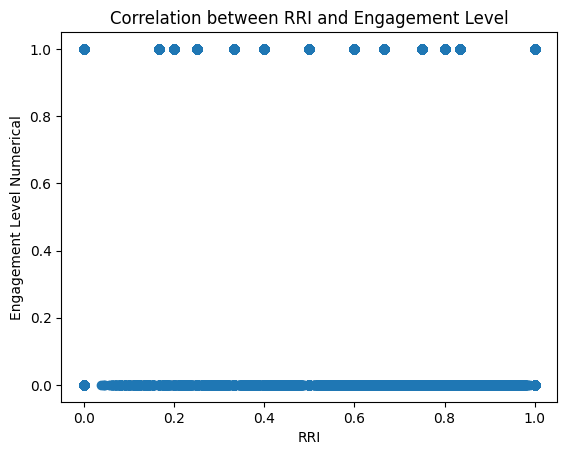

In [ ]:
# . Determine if there is any correlation between RRI and the engagement of users.

# Calculate the Pearson correlation coefficient and p-value
rri = rri.rename('RRI')  
engagement_rri = pd.merge(engagement, rri, on='Visitor Id')

# Convert 'Engagement Level' to numerical representation
label_encoder = LabelEncoder()
engagement_rri['Engagement Level Numerical'] = label_encoder.fit_transform(engagement_rri['Engagement Level'])

# Calculate the Pearson correlation and p-value
pearson_corr, pearson_pvalue = pearsonr(engagement_rri['RRI'], engagement_rri['Engagement Level Numerical'])

# Calculate the Spearman correlation coefficient and p-value
spearman_corr, spearman_pvalue = spearmanr(engagement_rri['RRI'], engagement_rri['Engagement Level'])

print("Pearson correlation coefficient:", pearson_corr)
print("Pearson p-value:", pearson_pvalue)
print("Spearman correlation coefficient:", spearman_corr)
print("Spearman p-value:", spearman_pvalue)

# The p-value less than 0.05 indicates a significant correlation
# Plotting the correlation
plt.scatter(engagement_rri['RRI'], engagement_rri['Engagement Level Numerical'])
plt.xlabel('RRI')
plt.ylabel('Engagement Level Numerical')
plt.title('Correlation between RRI and Engagement Level')
plt.show()

Based on these results:
Pearson correlation coefficient: 0.02571947115374782
Pearson p-value: 6.570202702890231e-11
Spearman correlation coefficient: 0.1663902599007453
Spearman p-value: 0.0

 There seems to be a weak correlation between RRI and the engagement level, although the nature of the correlation (linear or monotonic) is different based on the correlation coefficient used. In both cases however, the p-value is small suggesitng the correlation is statiscally significant

# Bonus Question

In [ ]:
# Display the first few rows of the DataFrame
print(df.head())


  Visitor Id  State  Device    City Country                Date  \
0  Visitor 1      4  Safari  Quebec  Canada  2022-09-01 0:07:45   
1  Visitor 2      2  Safari  Quebec  Canada  2022-09-01 0:08:17   
2  Visitor 2      4  Safari  Quebec  Canada  2022-09-01 0:08:22   
3  Visitor 2      4  Safari  Quebec  Canada  2022-09-01 0:08:23   
4  Visitor 2      2  Safari  Quebec  Canada  2022-09-01 0:08:37   

                                             Page  Source Category  
0                                               /       1           
1  /produit/GwnfnU1HFW85bon5lXV9DlO0L02LpQFGVQ586       2  produit  
2  /produit/shL4MwXvPqcXBthLvQGqyvk04uqPJRWZAKKmN       2  produit  
3  /produit/M7dYLKqdw665udILfLP09qbRerFjOF9z8NaPH       2  produit  
4  /produit/Y2sUJXsfJxVS8R3PlJnN0Csq5Z2oAjuJ8l9Ks       2  produit  
               State         Source
count  396276.000000  396276.000000
mean        2.376013    1919.618955
std         0.934487    3211.064489
min         1.000000       1.000000
25%

In [ ]:
# Generate summary statistics of the data
summary = df.describe()
print(summary)

               State         Source
count  396276.000000  396276.000000
mean        2.376013    1919.618955
std         0.934487    3211.064489
min         1.000000       1.000000
25%         2.000000       2.000000
50%         2.000000     117.000000
75%         3.000000    2593.000000
max         4.000000   12664.000000



In observing the data for the states:
The count of non-null values indicates that there are 396,276 valid entries in the 'State' column, implying that it is mostly populated and has a limited number of missing values.

The mean value of approximately 2.376 suggests that the average state value is around 2. This gives an indication of the central tendency of the data.
The standard deviation of approximately 0.934 implies that the 'State' values are relatively close to the mean, indicating a moderate spread or dispersion.

The minimum value of 1 and the maximum value of 4 demonstrate the range of possible state values.
The quartiles (25%, 50%, 75%) provide insights into the distribution of the data, indicating that 25% of the values are less than or equal to 2, 50% are less than or equal to 2 (median), and 75% are less than or equal to 3.

In observing the data for the source:
The count, mean, and standard deviation have similar interpretations to those in the 'State' column, indicating the number of valid entries, the average value, and the spread of the 'Source' values.
The minimum and maximum values illustrate the range of possible 'Source' values, with the minimum being 1 and the maximum being 12,664.
The quartiles provide information about the distribution of the 'Source' data, such as 25% of the values being less than or equal to 2, 50% (median) being less than or equal to 117, and 75% being less than or equal to 2,593.

In [ ]:
# Check if data needs cleaning

# 1. Check data types
print(df.dtypes)

# 2. Missing values
print()
print(df.isnull().sum())

# 3. Duplicate rows
print()
print(df.duplicated().sum())

# 4. Outliers (for numeric columns)
print()
numeric_cols = ['State']
print(df[numeric_cols].describe())

# 5. Inconsistent data
print()
print(df['State'].unique())

Visitor Id    object
State          int64
Device        object
City          object
Country       object
Date          object
Page          object
Source         int64
Category      object
dtype: object

Visitor Id        0
State             0
Device         3164
City          36556
Country        5382
Date              0
Page              0
Source            0
Category          0
dtype: int64

115

               State
count  396276.000000
mean        2.376013
std         0.934487
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000

[4 2 3 1]


We can observe that the data needs some cleaning from the results above. There are missing values, duplicates, inconsostent data and inconisistent types for some data

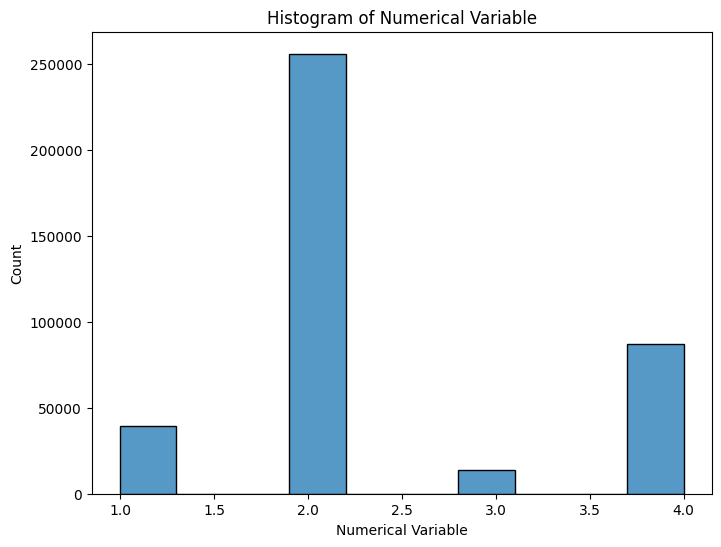

In [ ]:
# Histogram of State
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='State', bins=10)
plt.title('State Plot')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

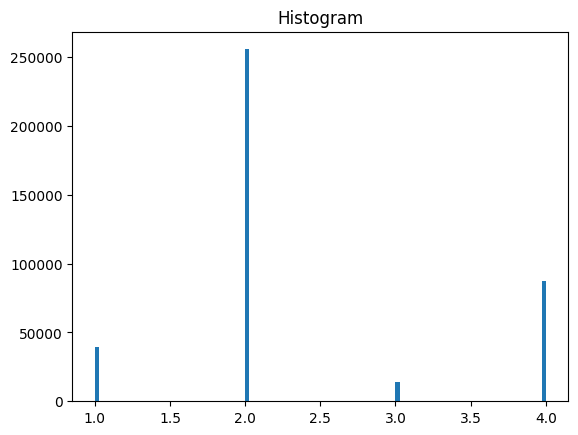

Skewness: 0.8059398815456025


In [ ]:
plt.figure()
plt.hist(df['State'], bins='auto')
plt.title('Histogram')
plt.show()

# Calculate skewness
skewness_value = stats.skew(df['State'])
print("Skewness:", skewness_value)

In relating to observing this data, A skewness value of 0.8059 indicates that the data has a moderate positive skew. Skewed data can lead to biased predictions, especially when the model is sensitive to imbalanced classes or outliers. The model may favor the majority class or fail to accurately predict rare events